In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import csv
import glob
import librosa
import librosa.display
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from Audio_Sentiment_Analysis.utils.Configuration import Configuration

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_iemocap.csv'
RAW_AUDIO_FILES = 'raw_audio_files.csv'

CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
config = Configuration.load_json(CONFIG_FILE)

## Extracting the 24 features selected from the eNTERFACE05 dataset study

In [2]:
chosen_features = {'var_mfcc15', 'min_mfcc17', 'std_chroma_stft', 'mean_zcr',
    'min_zcr', 'var_mfcc4', 'spikes_spec_cent', 'var_spec_bw', 'max_mfcc6',
    'min_mfcc19', 'max_mfcc13', 'max_mfcc5', 'var_mfcc9', 'min_mfcc7', 'var_mfcc1',
    'max_mfcc1', 'max_mfcc9', 'var_mel_spect', 'mean_spec_cont', 'var_mfcc2', 'max_mfcc10',
    'min_spec_cent', 'var_mfcc14', 'var_mfcc3'}

In [4]:
headers = [
    'File', 'Interaction', 'Gender', 'Duration', 'Emotion', 'Emotion_Id',
    'Valence', 'Activation', 'Dominance',
    'std_chroma_stft', 'mean_zcr', 'min_zcr',
    'var_mel_spect', 'spikes_spec_cent', 'min_spec_cent',
    'var_spec_bw', 'mean_spec_cont', 
    'var_mfcc1', 'max_mfcc1', 'var_mfcc2', 'var_mfcc3', 'var_mfcc4',
    'max_mfcc5', 'max_mfcc6', 'min_mfcc7', 'var_mfcc9', 'max_mfcc9',
    'max_mfcc10', 'max_mfcc13', 'var_mfcc14', 'var_mfcc15', 
    'min_mfcc17', 'min_mfcc19'
]

In [63]:
headers_raw = [
    'File', 'Interaction', 'Gender', 'Duration', 'Emotion', 'Emotion_Id',
    'Valence', 'Activation', 'Dominance'
]

In [5]:
def spikes(data):
    if len(data.shape) != 1:
        data = np.concatenate(data)
    mean = np.mean(data)
    std = np.std(data)
    threshold = mean + std * 2 / 100
    num_spikes = 0
    for value in data:
        if value >= threshold:
            num_spikes += 1

    return num_spikes

In [2]:
emotion_label = {
    'ang': "angry",
    'hap': "happy",
    'sad': "sad",
    'neu': "neutral",
    'fru': "frustrated",
    'exc': "excited",
    'fea': "fearful",
    'sur': "surprised",
    'dis': "disgusted",
    'xxx': "other",
    'oth': "other"
}

emotion_number = {
    'ang': 0,
    'hap': 1,
    'sad': 2,
    'neu': 3,
    'fru': 4,
    'exc': 5,
    'fea': 6,
    'sur': 7,
    'dis': 8,
    'oth': 9,
    'xxx': 9,
}

In [67]:
def extract_features(audio_file, duration, emotion, valence, activation, dominance, writer):
    file = audio_file.split(".")[-2].split("/")[-1]
    acting = "improvised" if file.split("_")[1][:5] == "impro" else "scripted"
    gender = "Male" if file.split("_")[-1][0] == 'M' else "Female"

    y, sr = librosa.load(audio_file, res_type='kaiser_fast')

    std_chroma_stft = np.std(librosa.feature.chroma_stft(y=y, sr=sr))
    zcr = librosa.feature.zero_crossing_rate(y=y)
    mean_zcr = np.mean(zcr)
    min_zcr = np.min(zcr)
    var_mel_spect = np.var(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=config.n_mels))
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spikes_spec_cent = spikes(spec_cent)
    min_spec_cent = np.min(spec_cent)
    var_spec_bw = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    mean_spec_cont = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    var_mfcc1 = np.var(mfcc[0])
    max_mfcc1 = np.max(mfcc[0])
    var_mfcc2 = np.var(mfcc[1])
    var_mfcc3 = np.var(mfcc[2])
    var_mfcc4 = np.var(mfcc[3])
    max_mfcc5 = np.max(mfcc[4])
    max_mfcc6 = np.max(mfcc[5])
    min_mfcc7 = np.min(mfcc[6])
    var_mfcc9 = np.var(mfcc[8])
    max_mfcc9 = np.max(mfcc[8])
    max_mfcc10 = np.max(mfcc[9])
    max_mfcc13 = np.max(mfcc[12])
    var_mfcc14 = np.var(mfcc[13])
    var_mfcc15 = np.var(mfcc[14])
    min_mfcc17 = np.min(mfcc[16])
    min_mfcc19 = np.min(mfcc[18])

    features_str = f'{file} {acting} {gender} {duration} {emotion_label[emotion]} {emotion_number[emotion]}\
        {valence} {activation} {dominance}\
        {std_chroma_stft} {mean_zcr} {min_zcr} {var_mel_spect} {spikes_spec_cent} {min_spec_cent}\
        {var_spec_bw} {mean_spec_cont} {var_mfcc1} {max_mfcc1} {var_mfcc2} {var_mfcc3} {var_mfcc4}\
        {max_mfcc5} {max_mfcc6} {min_mfcc7} {var_mfcc9} {max_mfcc9} {max_mfcc10} {max_mfcc13}\
        {var_mfcc14} {var_mfcc15} {min_mfcc17} {min_mfcc19}'

    writer.writerow(features_str.split())

In [59]:
def process_data(audio_dir, headers, proc_feat_dataset):
    # Create a CSV for storing all processed features and write the header
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(headers)

    print("Processing audio files from all dialogs:")
    for file_path in tqdm(glob.glob(audio_dir+'/Session[0-9]*/dialog/EmoEvaluation/*.txt')):
        emoEvalFile = open(file_path)

        for line in emoEvalFile:
            if line[0] == '[':
                args = line.split()
                duration = float(args[2][:-1]) - float(args[0][1:])
                # on windows
                audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/'+file_path.split("\\")[-1][:-4]+f'/{args[3]}.wav'
                # on linux/macOS
                # audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/{file_path.split("/")[-1][:-4]}/{args[3]}.wav'
                extract_features(audio_file, duration, args[4], args[5][1:-1], args[6][:-1], args[7][:-1], writer)

In [148]:
process_data(AUDIO_DIR, headers, EXTRACTED_FEATURES_FILE)

Processing audio files from all dialogs:


100%|██████████| 151/151 [09:47<00:00,  3.89s/it]


In [62]:
def extract_raw_data(audio_dir, headers, raw_audio_dataset):
   file = open(raw_audio_dataset, 'w', newline='')
   writer = csv.writer(file)
   writer.writerow(headers)

   print("Processing audio files from all dialogs:")
   for file_path in tqdm(glob.glob(audio_dir+'/Session[0-9]*/dialog/EmoEvaluation/*.txt')):
      emoEvalFile = open(file_path)

      for line in emoEvalFile:
         if line[0] == '[':
            args = line.split()
            duration = float(args[2][:-1]) - float(args[0][1:])
            # on windows
            #  audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/'+file_path.split(
            #      "\\")[-1][:-4]+f'/{args[3]}.wav'
            # on linux/macOS
            audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/{file_path.split("/")[-1][:-4]}/{args[3]}.wav'
            emotion, valence, activation, dominance = args[4], args[5][1:-1], args[6][:-1], args[7][:-1]
            file = audio_file.split(".")[-2].split("/")[-1]
            acting = "improvised" if file.split("_")[1][:5] == "impro" else "scripted"
            gender = "Male" if file.split("_")[-1][0] == 'M' else "Female"
            
            features_str = f'{audio_file} {acting} {gender} {duration} {emotion_label[emotion]} {emotion_number[emotion]}\
                {valence} {activation} {dominance}'

            writer.writerow(features_str.split())

In [64]:
extract_raw_data(AUDIO_DIR, headers_raw, RAW_AUDIO_FILES)

Processing audio files from all dialogs:


100%|████████████████████████████████████████| 151/151 [00:00<00:00, 488.21it/s]


## Data Study

In [3]:
pd.read_csv(RAW_AUDIO_FILES)

,File,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance
0,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Female,1.5900,neutral,3,3.0000,2.0000,1.5000
1,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Female,1.7460,other,9,3.0000,2.5000,2.5000
2,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Female,1.9840,frustrated,4,2.0000,2.5000,3.0000
3,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Female,2.8500,other,9,2.0000,2.5000,3.0000
4,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Female,5.4400,other,9,2.0000,3.0000,3.5000
...,...,...,...,...,...,...,...,...,...
10034,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Male,2.6800,sad,2,2.0000,2.6667,2.6667
10035,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Male,2.3300,other,9,2.6667,2.0000,1.6667
10036,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Male,2.1525,sad,2,2.6667,2.3333,3.0000
10037,/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Ses...,scripted,Male,2.6500,angry,0,2.6667,3.0000,3.6667


In [4]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df

Number of Audio Files: 10039


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_F012,improvised,Female,2.750,angry,0,2.0,3.5,3.5,0.296270,0.082856,...,39.327560,-40.651329,42.375973,19.492970,19.512123,18.821735,47.666279,51.472340,-18.892769,-27.943581
Ses01F_impro04_F028,improvised,Female,2.010,angry,0,2.0,3.5,3.5,0.319851,0.086560,...,62.818893,-40.228039,84.092949,24.274593,11.059961,36.497154,29.247034,61.287384,-17.456673,-15.254041
Ses01F_impro04_F029,improvised,Female,3.160,angry,0,1.5,4.0,4.0,0.298296,0.085880,...,29.858166,-33.455795,164.847565,34.833263,22.882631,33.635147,118.356186,128.460770,-32.842518,-12.516586
Ses01F_impro04_F030,improvised,Female,3.185,angry,0,1.5,3.5,4.0,0.316109,0.106300,...,48.537384,-38.774422,178.178299,24.138340,11.319570,35.046803,183.465393,119.128494,-13.127378,-24.713459
Ses01F_impro04_F031,improvised,Female,4.400,angry,0,1.5,3.0,3.5,0.314387,0.065918,...,44.125771,-49.090309,100.364433,35.686844,29.594337,11.990172,68.253944,51.992161,-20.573139,-20.019981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses05M_script03_2_M013,scripted,Male,9.340,other,10,2.0,3.5,4.0,0.314951,0.063627,...,58.600712,-46.007534,113.818436,32.636822,28.463696,25.335880,78.160225,66.925186,-27.014687,-21.044426
Ses05M_script03_2_M014,scripted,Male,4.150,other,10,1.5,3.5,4.0,0.315053,0.067145,...,73.493271,-54.896301,162.575638,31.630028,12.225033,33.560890,87.977707,42.288971,-24.003210,-19.897762
Ses05M_script03_2_M018,scripted,Male,2.170,other,10,3.5,3.0,3.0,0.302163,0.062219,...,51.708046,-34.321487,181.688660,23.869041,14.644627,14.957552,41.870499,43.103497,-20.033688,-19.955128


## Using the data in SOA

In [15]:
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

In [16]:
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


In [17]:
df.groupby(['Gender']).agg({'Gender': ['count']})

,Gender
,count
Gender,
Female,2649
Male,2882


## Audio Clip Durations

In [18]:
df.groupby(['Emotion']).agg({'Duration': ['mean']})

,Duration
,mean
Emotion,
angry,4.512970
happy,4.621055
neutral,3.901985
sad,5.496464


In [19]:
df[["Duration"]].min()

Duration    0.585
dtype: float64

In [20]:
df[["Duration"]].mean()

Duration    4.549016
dtype: float64

In [21]:
df[["Duration"]].max()

Duration    34.1388
dtype: float64

## Improvised vs Scripted Data

In [22]:
df.groupby(['Interaction']).agg({'Interaction': ['count']})

,Interaction
,count
Interaction,
improvised,2943
scripted,2588


In [43]:
df.groupby(['Emotion', 'Interaction']).agg({'Emotion': ['count']})

Emotion
                      count
Emotion Interaction        
angry   improvised      289
        scripted        814
happy   improvised      947
        scripted        689
neutral improvised     1099
        scripted        609
sad     improvised      608
        scripted        476

### Valence Variation for each Emotion Label

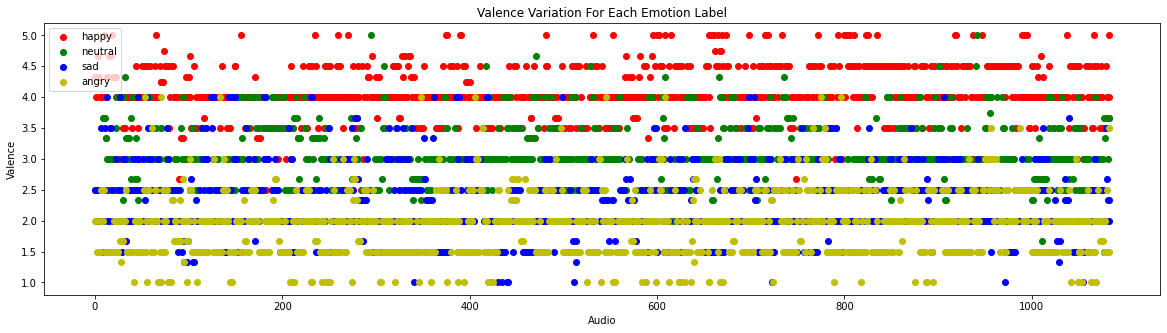

In [23]:
plt.figure(figsize=(20,5))
plt.title("Valence Variation For Each Emotion Label")
plt.xlabel("Audio")
plt.ylabel("Valence")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'happy']['Valence'][:1084], 'ro', label="happy")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'neutral']['Valence'][:1084], 'go', label="neutral")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'sad']['Valence'][:1084], 'bo', label="sad")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'angry']['Valence'][:1084], 'yo', label="angry")
plt.legend(loc="upper left")
plt.show()

### Activation Variation for each Emotion Label

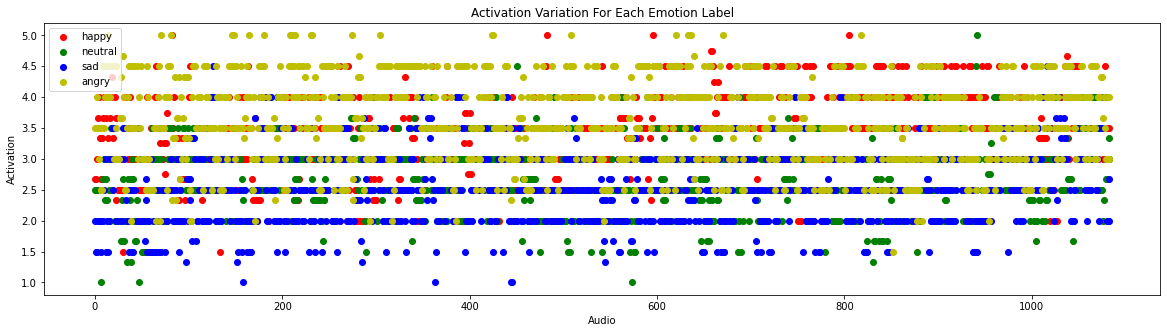

In [24]:
plt.figure(figsize=(20,5))
plt.title("Activation Variation For Each Emotion Label")
plt.xlabel("Audio")
plt.ylabel("Activation")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'happy']['Activation'][:1084], 'ro', label="happy")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'neutral']['Activation'][:1084], 'go', label="neutral")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'sad']['Activation'][:1084], 'bo', label="sad")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'angry']['Activation'][:1084], 'yo', label="angry")
plt.legend(loc="upper left")
plt.show()

### Dominance Variation for each Emotion Label

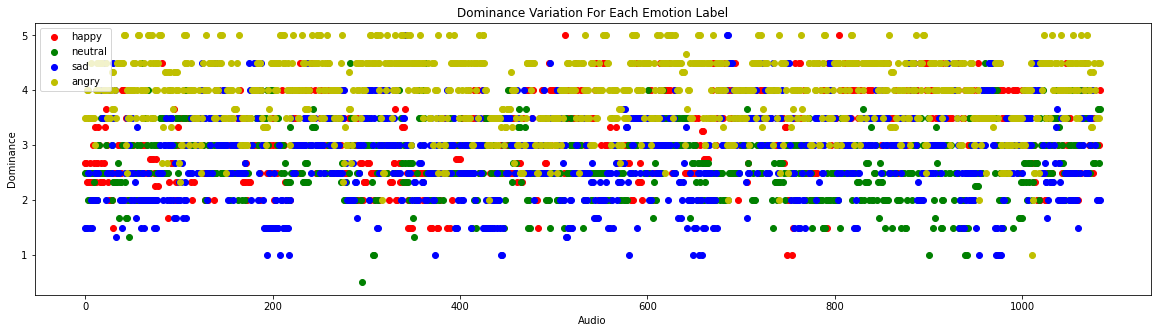

In [25]:
plt.figure(figsize=(20,5))
plt.title("Dominance Variation For Each Emotion Label")
plt.xlabel("Audio")
plt.ylabel("Dominance")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'happy']['Dominance'][:1084], 'ro', label="happy")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'neutral']['Dominance'][:1084], 'go', label="neutral")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'sad']['Dominance'][:1084], 'bo', label="sad")
plt.plot([i for i in range(1084)], df.loc[df['Emotion'] == 'angry']['Dominance'][:1084], 'yo', label="angry")
plt.legend(loc="upper left")
plt.show()

## Improvised vs Scripted Data

In [28]:
df_improv = df[df['Interaction'] == 'improvised']
df_improv.groupby(['Emotion']).agg({'Emotion': ['count']})

,Emotion
,count
Emotion,
angry,289
happy,947
neutral,1099
sad,608


In [190]:
def labels_variations(emotions):
    df_improv = df[df['Interaction'] == 'improvised']
    df_scripted = df[df['Interaction'] == 'scripted']

    def scatter_plot(pos_x, pos_y, title, ylabel, df, bar_plot_data = [[], []]):
        def get_min_len(emotion):
            x = len(df_improv.loc[df_improv['Emotion'] == emotion][ylabel])
            y = len(df_scripted.loc[df_scripted['Emotion'] == emotion][ylabel])
            return x if x < y else y

        def plot(emotion, color):
            if emotion in emotions:
                data = df.loc[df['Emotion'] == emotion][ylabel][:get_min_len(emotion)]
                bar_plot_data[0].append(emotion)
                bar_plot_data[1].append(data.values)
                ax.plot([i for i in range(len(data))], data, color, label=f"{emotion} - max: {np.max(data)}, mean: {np.mean(data):.1f}, min: {np.min(data)}")
        
        ax = plt.subplot(grid[pos_x, pos_y])
        ax.set_title(title)
        ax.set(xlabel="Audio", ylabel=ylabel)

        plot('happy', 'ro')
        plot('neutral', 'go')
        plot('sad', 'bo')
        plot('angry', 'yo')

        ax.set_yticks(yticks)
        ax.legend(loc="upper left")
        return bar_plot_data

    def violin_plot(pos_x, title, ylabel, bar_plot_data):
        ax = plt.subplot(grid[pos_x, :])
        ax.set_title(title)
        ax.set(xlabel="Audio", ylabel=ylabel)

        x = len(bar_plot_data[0])//2
        df_barplot = pd.DataFrame(
            zip(
                bar_plot_data[0]*x,
                ['Improvised']*x+['Scripted']*x,
                bar_plot_data[1]
            ),
            columns=["Emotion", "Acting Type", ylabel]
        )
        df_barplot = df_barplot.explode(ylabel)
        df_barplot[ylabel] = df_barplot[ylabel].astype('float')
        sns.violinplot(x="Emotion", y=ylabel, hue="Acting Type", inner='quartile',
            data=df_barplot, ax=ax, palette="Set3", split=True, scale="count")

        ax.set_yticks(yticks)
        ax.legend(loc="upper left")

    grid = plt.GridSpec(6, 2, wspace=.1, hspace=.4)
    plt.figure(figsize=(24, 30), tight_layout=True)
    
    if len(emotions) == 4:
        yticks = [float(i)/10.0 for i in range(0, 75, 5)]
    else:
        yticks = [float(i)/10.0 for i in range(0, 65, 5)]

    bar_plot_data = scatter_plot(0, 0, "Valence Variation on Improvised SOA Data", "Valence", df_improv)
    bar_plot_data = scatter_plot(0, 1, "Valence Variation on Scripted SOA Data", "Valence", df_scripted)
    violin_plot(1, "Valence Variation on All SOA Data", "Valence", bar_plot_data)
    bar_plot_data = scatter_plot(2, 0, "Activation Variation on Improvised SOA Data", "Activation", df_improv)
    bar_plot_data = scatter_plot(2, 1, "Activation Variation on Scripted SOA Data", "Activation", df_scripted)
    violin_plot(3, "Activation Variation on All SOA Data", "Activation", bar_plot_data)
    bar_plot_data = scatter_plot(4, 0, "Dominance Variation on Improvised SOA Data", "Dominance", df_improv)
    bar_plot_data = scatter_plot(4, 1, "Dominance Variation on Scripted SOA Data", "Dominance", df_scripted)
    violin_plot(5, "Dominance Variation on All SOA Data", "Dominance", bar_plot_data)
    plt.show()

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


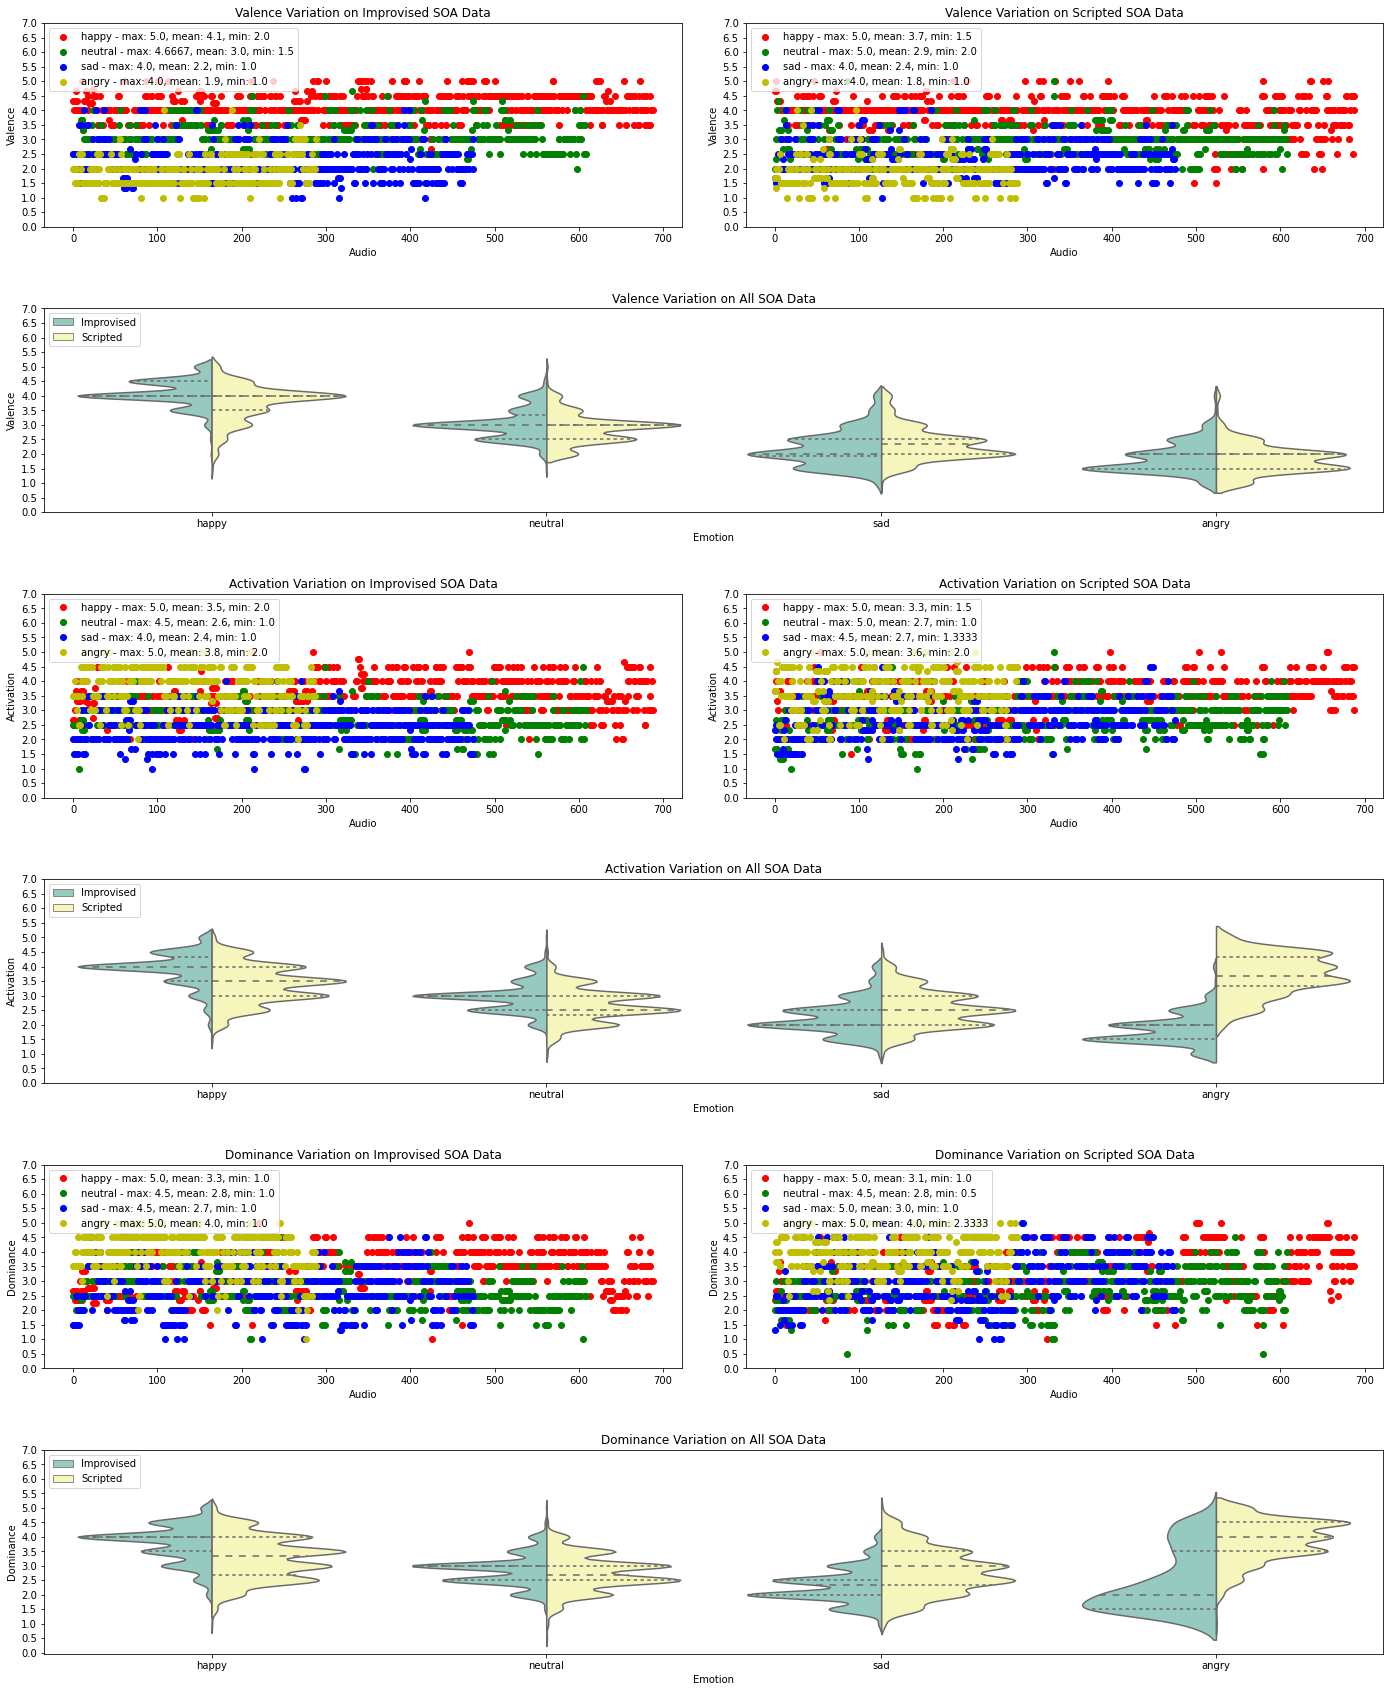

In [191]:
labels_variations(['happy', 'sad', 'angry', 'neutral'])

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


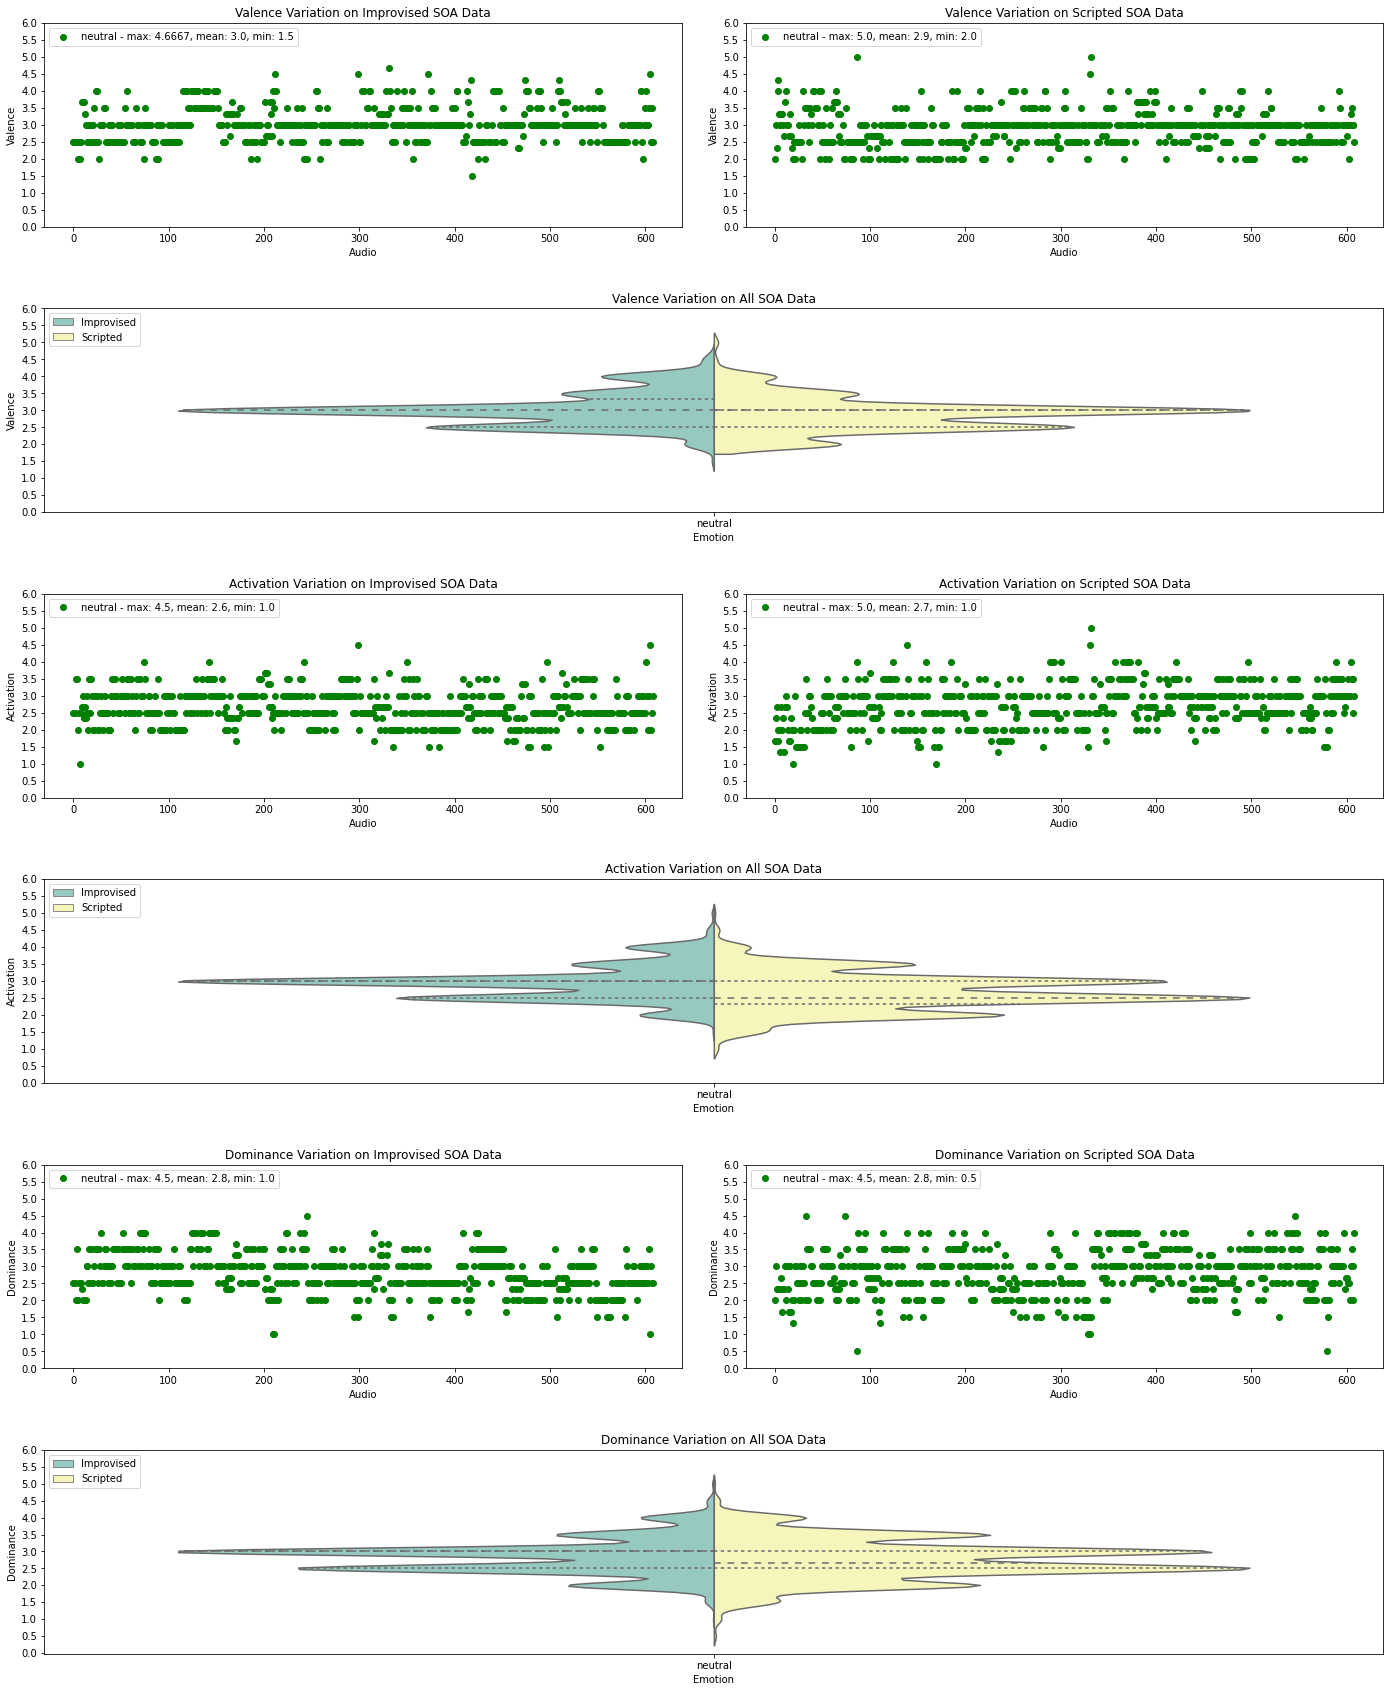

In [192]:
labels_variations(['neutral'])

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


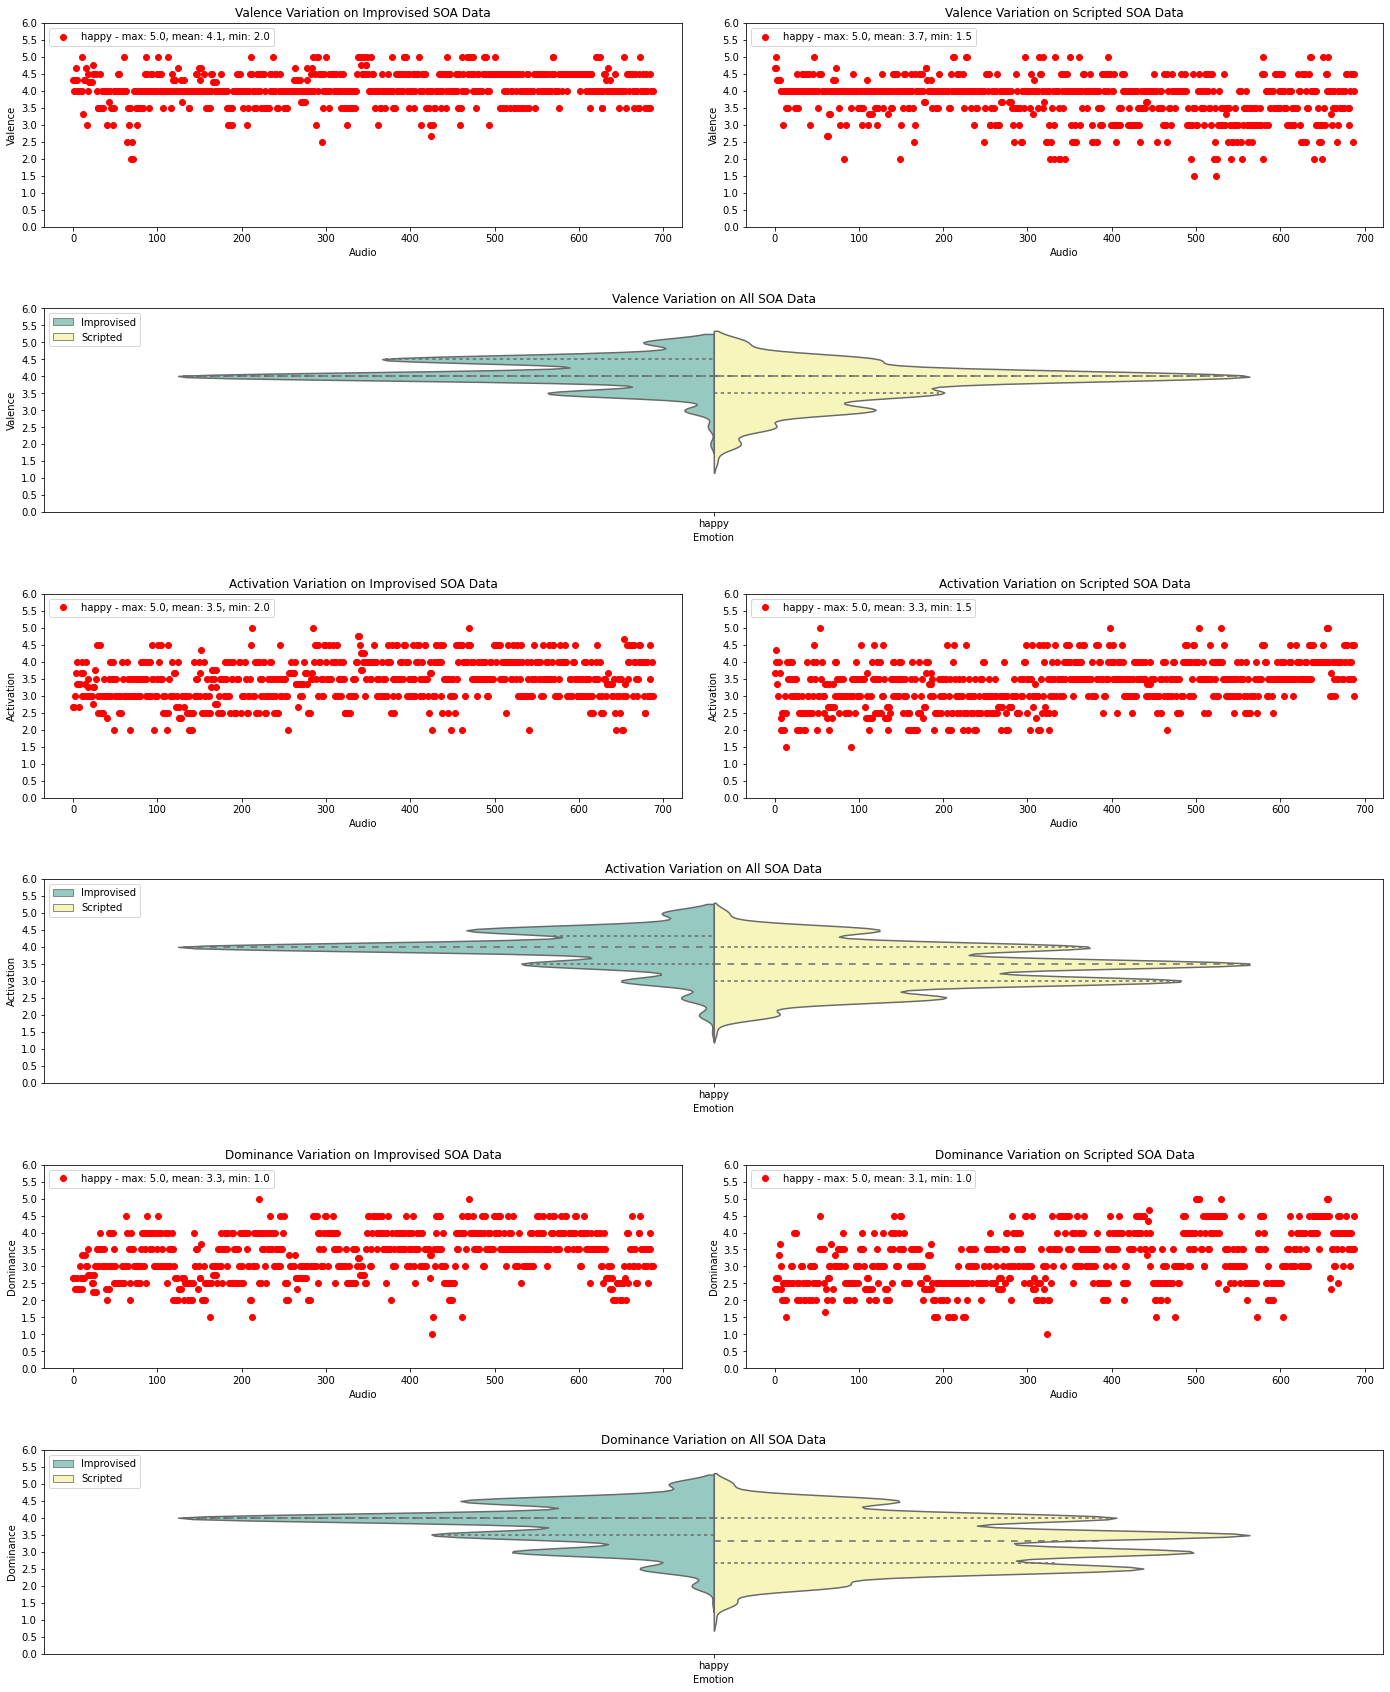

In [193]:
labels_variations(['happy'])

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


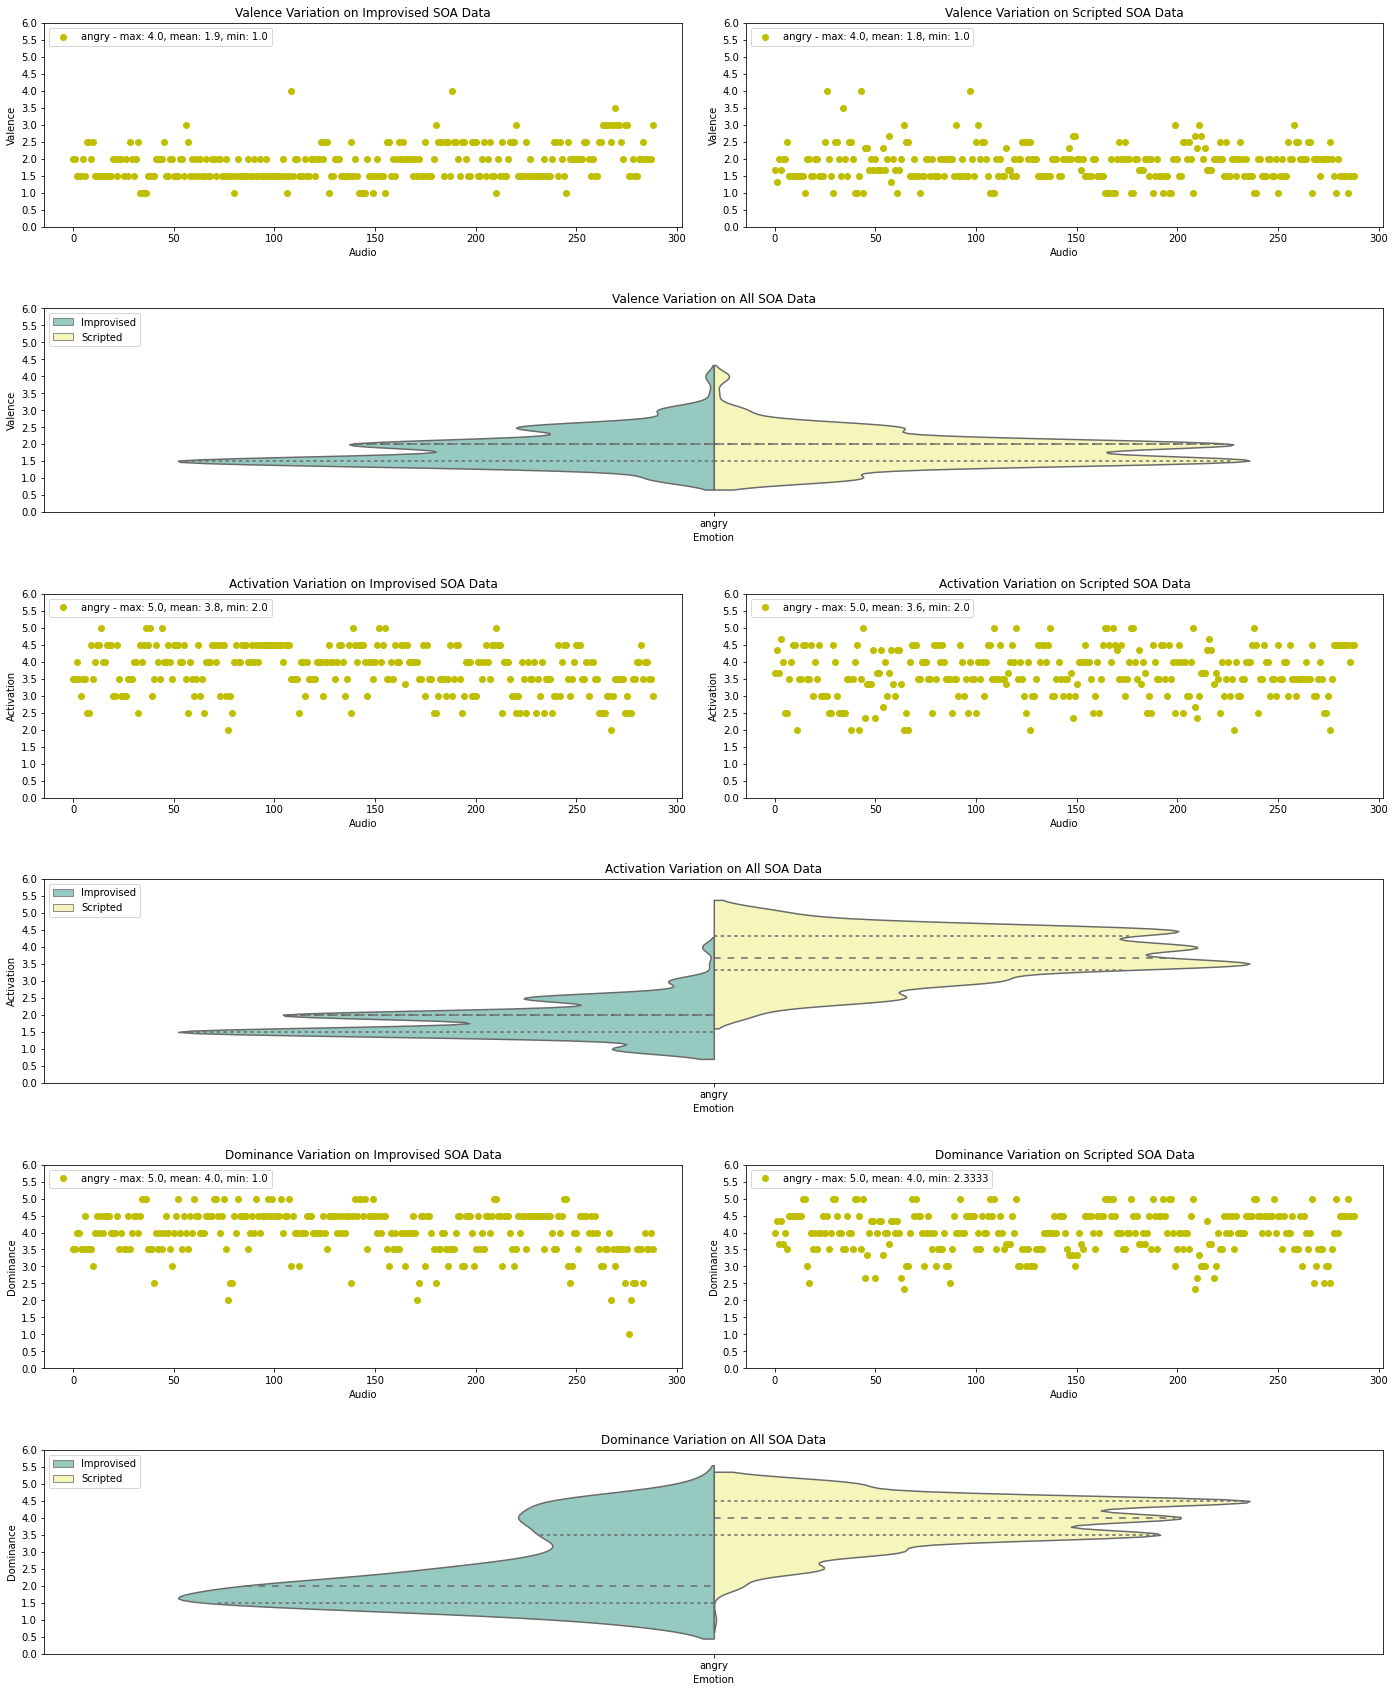

In [194]:
labels_variations(['angry'])

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


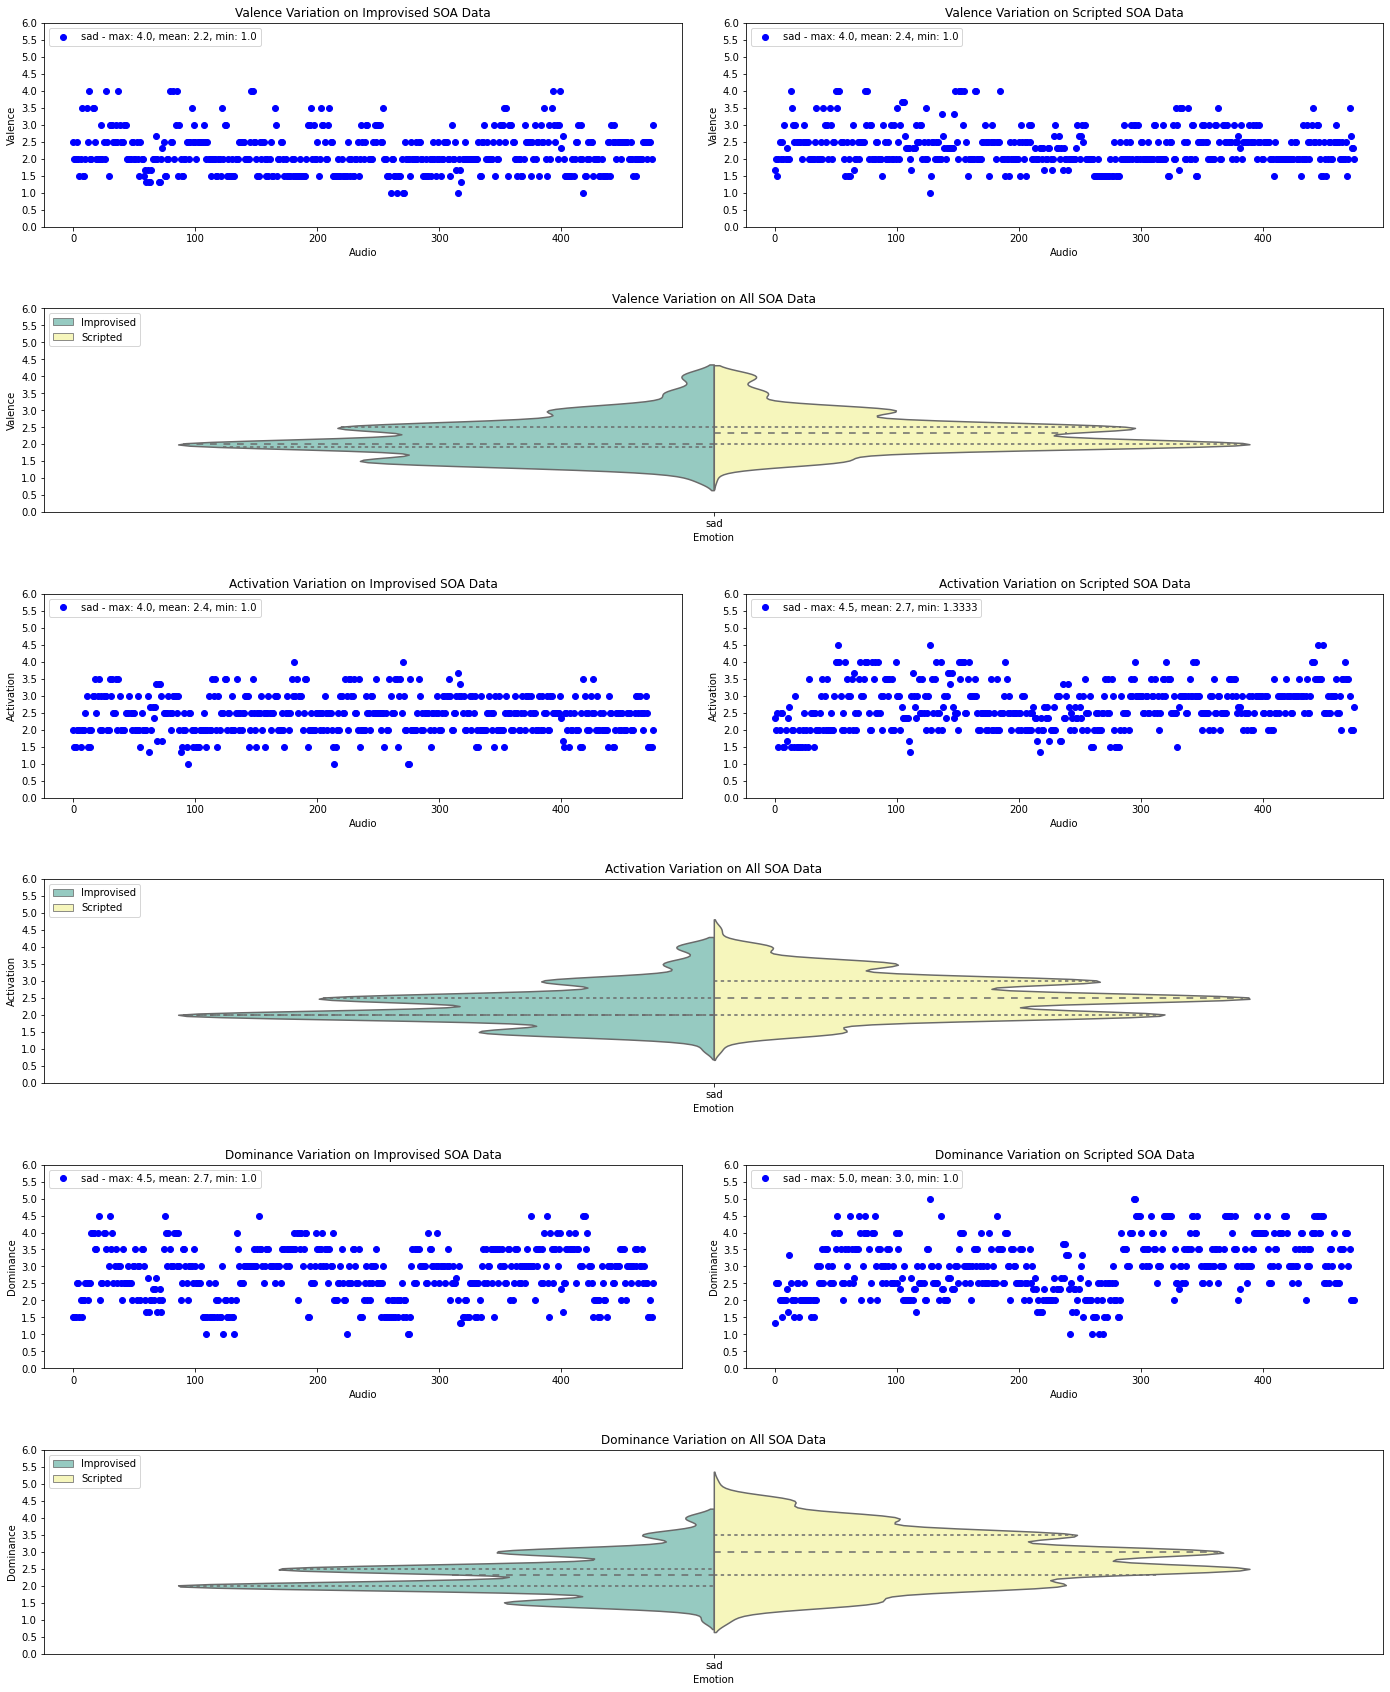

In [195]:
labels_variations(['sad'])